### Notebook for the label transfer of Healthy Human Heart to mouse heart using `scANVI`

- **Developed by:** Carlos Talavera-López Ph.D
- **Würzburg Institute for Systems Immunology & Julius-Maximilian-Universität Würzburg**
- v240103

### Import required modules

In [1]:
import scvi
import torch
import anndata
import warnings
import numpy as np
import scanpy as sc
import pandas as pd
import plotnine as p
from pywaffle import Waffle
import matplotlib.pyplot as plt
from scib_metrics.benchmark import Benchmarker

/home/ceger/miniforge3/envs/heart_multiome-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Set up working environment

In [2]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 180, color_map = 'magma_r', dpi_save = 300, vector_friendly = True, format = 'svg')

-----
anndata     0.10.5.post1
scanpy      1.9.8
-----
Cython              3.0.9
PIL                 10.2.0
absl                NA
annotated_types     0.6.0
anyio               NA
asttokens           NA
backoff             2.2.1
brotli              1.1.0
bs4                 4.12.3
certifi             2024.02.02
cffi                1.16.0
charset_normalizer  3.3.2
chex                0.1.85
click               8.1.7
colorama            0.4.6
comm                0.2.1
contextlib2         NA
croniter            NA
cycler              0.12.1
cython              3.0.9
cython_runtime      NA
dateutil            2.9.0
debugpy             1.8.1
decorator           5.1.1
deepdiff            6.7.1
docrep              0.3.2
etils               1.7.0
exceptiongroup      1.2.0
executing           2.0.1
fastapi             0.110.0
flax                0.8.1
fsspec              2024.2.0
gmpy2               2.1.2
google              NA
h5py                3.10.0
idna                3.6
igraph          

In [3]:
torch.set_float32_matmul_precision('high')

In [4]:
warnings.simplefilter(action = 'ignore')
scvi.settings.seed = 1712
%config InlineBackend.print_figure_kwargs = {'facecolor' : "w"}
%config InlineBackend.figure_format = 'retina'

Global seed set to 1712


In [5]:
arches_params = dict(
    use_layer_norm = "both",
    use_batch_norm = "none",
    encode_covariates = True,
    dropout_rate = 0.2,
    n_layers = 2,
)

### Read in Healthy data

In [6]:
reference = sc.read_h5ad('../../data/hca_heart_global_ctl230918_states_formatted.h5ad')
reference

AnnData object with n_obs × n_vars = 452506 × 22260
    obs: 'cell_source', 'cell_type', 'donor', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'cell_states', 'seed_labels'
    var: 'gene_ids-Harvard-Nuclei-full', 'feature_types-Harvard-Nuclei-full', 'gene_ids-Sanger-Nuclei-full', 'feature_types-Sanger-Nuclei-full', 'gene_ids-Sanger-Cells-full', 'feature_types-Sanger-Cells-full', 'gene_ids-Sanger-CD45-full', 'feature_types-Sanger-CD45-full', 'n_cells-myeloid', 'n_counts-myeloid'

In [7]:
reference.obs['cell_states'].value_counts()

vCM1             71162
PC1_vent         50095
EC1_cap          27417
FB1              26632
vCM2             25658
                 ...  
CD4+T_Th1           74
gdT                 24
NC6                 24
unclassfied.2       20
CD4+T_Th17           8
Name: cell_states, Length: 79, dtype: int64

- Remove annotations with less than 10 cells

In [8]:
reference.obs['seed_labels'] = reference.obs['cell_states'].copy()
reference.obs['seed_labels'].value_counts()

vCM1             71162
PC1_vent         50095
EC1_cap          27417
FB1              26632
vCM2             25658
                 ...  
CD4+T_Th1           74
gdT                 24
NC6                 24
unclassfied.2       20
CD4+T_Th17           8
Name: seed_labels, Length: 79, dtype: int64

In [9]:
reference.obs['seed_labels'].cat.categories

Index(['Adip1', 'Adip2', 'Adip3', 'Adip4', 'B', 'B_plasma', 'CD14+Mo',
       'CD4+T_Tfh', 'CD4+T_Th1', 'CD4+T_Th17', 'CD4+T_Th2', 'CD4+T_act',
       'CD4+T_naive', 'CD4+T_reg', 'CD69+Mo', 'CD8+T_cytox', 'CD8+T_em',
       'CD8+T_te', 'CD8+T_trans', 'Cycling_T/NK', 'DC2', 'DOCK4+aMØ',
       'DOCK4+vMØ', 'EC10_CMC-like', 'EC1_cap', 'EC2_cap', 'EC3_cap',
       'EC4_immune', 'EC5_art', 'EC6_ven', 'EC7_atria', 'EC8_ln',
       'EC9_FB-like', 'FB1', 'FB2', 'FB3', 'FB4', 'FB5', 'FB6', 'ILC',
       'LYVE1+MØ1', 'LYVE1+MØ2', 'M2MØ', 'MAIT-like', 'Mast', 'Meso', 'MoMø',
       'NC1', 'NC2', 'NC3', 'NC4', 'NC5', 'NC6', 'NK_CD16hi', 'NK_CD56hi',
       'NØ', 'PC1_vent', 'PC2_atria', 'PC3_str', 'PC4_CMC-like', 'SMC1_basic',
       'SMC2_art', 'TREM2+MØ', 'aCM1', 'aCM2', 'aCM3', 'aCM4', 'aCM5', 'gdT',
       'nøMo', 'pDC', 'proIMØ', 'unclassfied.1', 'unclassfied.2', 'vCM1',
       'vCM2', 'vCM3', 'vCM4', 'vCM5'],
      dtype='object')

### Subset populations of interest

In [10]:
reference = reference[~reference.obs['seed_labels'].isin(['nan'])]
reference.obs['seed_labels'].value_counts()

vCM1             71162
PC1_vent         50095
EC1_cap          27417
FB1              26632
vCM2             25658
                 ...  
CD4+T_Th1           74
gdT                 24
NC6                 24
unclassfied.2       20
CD4+T_Th17           8
Name: seed_labels, Length: 79, dtype: int64

In [11]:
sc.pp.filter_cells(reference, min_genes = 200)
sc.pp.filter_cells(reference, min_counts = 100)

In [12]:
reference.obs['cell_source'].value_counts()

Sanger-Nuclei     165337
Harvard-Nuclei    164929
Sanger-CD45        76966
Sanger-Cells       45274
Name: cell_source, dtype: int64

### Read in other query

In [13]:
query = sc.read_h5ad('../../data/Kdm6aKO_ALL_GEX-CB_QCed_ctl240116.raw.h5ad')
query.obs['cell_source'] = 'Becker-Nuclei'
query.obs['seed_labels'] = 'Unknown'
query.obs['donor'] = query.obs['sample'].copy()
query

AnnData object with n_obs × n_vars = 46135 × 32285
    obs: 'sample', 'genotype', 'group', 'file', 'batch', 'n_genes', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'cell_source', 'seed_labels', 'donor'
    var: 'gene_ids', 'feature_types', 'genome', 'modality', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'sample_colors'
    layers: 'counts', 'sqrt_norm'

In [14]:
sc.pp.filter_cells(query, min_genes = 200)
sc.pp.filter_cells(query, min_counts = 100)

### Change gene symbols for label transfer

In [15]:
query.var_names = [gene_name.upper() for gene_name in query.var_names]
query.var_names

Index(['XKR4', 'GM1992', 'GM19938', 'GM37381', 'RP1', 'SOX17', 'GM37587',
       'GM37323', 'MRPL15', 'LYPLA1',
       ...
       'GM16367', 'AC163611.1', 'AC163611.2', 'AC140365.1', 'AC124606.2',
       'AC124606.1', 'AC133095.2', 'AC133095.1', 'AC234645.1', 'AC149090.1'],
      dtype='object', length=32285)

In [16]:
adata = reference.concatenate(query, batch_key = 'batch', batch_categories = ['reference', 'query'], join = 'inner')
adata

AnnData object with n_obs × n_vars = 498641 × 14249
    obs: 'cell_source', 'cell_type', 'donor', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'cell_states', 'seed_labels', 'genotype', 'group', 'file', 'batch', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score'
    var: 'gene_ids-query', 'feature_types-query', 'genome-query', 'modality-query', 'mt-query', 'ribo-query', 'n_cells_by_counts-query', 'mean_counts-query', 'pct_dropout_by_counts-query', 'total_counts-query', 'gene_ids-Harvard-Nuclei-full-reference', 'feature_types-Harvard-Nuclei-full-reference', 'gene_ids-Sanger-Nuclei-full-reference', 'feature_types-Sanger-Nuclei-full-reference', 'gene_ids-Sanger-Cells-full-reference', 'feature_types-Sanger-Cells-full-reference', 'gene_ids-Sanger-CD45-full-reference', 'feature_types-Sanger-CD45-ful

In [17]:
adata.obs['seed_labels'] = adata.obs['seed_labels'].astype('category')
adata.obs['seed_labels'].value_counts()

vCM1             71162
PC1_vent         50095
Unknown          46135
EC1_cap          27417
FB1              26632
                 ...  
CD4+T_Th1           74
gdT                 24
NC6                 24
unclassfied.2       20
CD4+T_Th17           8
Name: seed_labels, Length: 80, dtype: int64

In [18]:
adata.obs['batch'].value_counts()

reference    452506
query         46135
Name: batch, dtype: int64

### Select HVGs

In [19]:
adata_raw = adata.copy()
adata.layers['counts'] = adata.X.copy()

sc.pp.highly_variable_genes(
    adata,
    flavor = "seurat_v3",
    n_top_genes = 7000,
    layer = "counts",
    batch_key = "sample",
    subset = True,
    span = 1
    )

adata

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


AnnData object with n_obs × n_vars = 498641 × 7000
    obs: 'cell_source', 'cell_type', 'donor', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'cell_states', 'seed_labels', 'genotype', 'group', 'file', 'batch', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score'
    var: 'gene_ids-query', 'feature_types-query', 'genome-query', 'modality-query', 'mt-query', 'ribo-query', 'n_cells_by_counts-query', 'mean_counts-query', 'pct_dropout_by_counts-query', 'total_counts-query', 'gene_ids-Harvard-Nuclei-full-reference', 'feature_types-Harvard-Nuclei-full-reference', 'gene_ids-Sanger-Nuclei-full-reference', 'feature_types-Sanger-Nuclei-full-reference', 'gene_ids-Sanger-Cells-full-reference', 'feature_types-Sanger-Cells-full-reference', 'gene_ids-Sanger-CD45-full-reference', 'feature_types-Sanger-CD45-full

### Transfer of annotation with scANVI

In [20]:
if torch.cuda.is_available():
    num_devices = torch.cuda.device_count()
    print("Available CUDA devices:")
    for i in range(num_devices):
        print(f"  {i}: {torch.cuda.get_device_name(i)}")
    device = torch.device("cuda:1") 
    print(f"Using CUDA device: {device}")
    torch.cuda.set_device(device)
else:
    print("CUDA is not available. Using CPU.")
    device = torch.device("cpu")

Available CUDA devices:
  0: NVIDIA RTX 6000 Ada Generation
  1: NVIDIA RTX 6000 Ada Generation
Using CUDA device: cuda:1


In [21]:
scvi.model.SCVI.setup_anndata(
    adata,
    batch_key='sample',
    labels_key='seed_labels',
    layer='counts',
    categorical_covariate_keys=['donor'],
)

In [22]:
scvi_model = scvi.model.SCVI(
    adata,
    n_latent=50,
    n_layers=3,
    dispersion='gene-batch',
    gene_likelihood='nb'
)

In [23]:
scvi_model.train(
    75,
    check_val_every_n_epoch=1,
    enable_progress_bar=True,
    accelerator='gpu',
    devices=[1],
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 75/75: 100%|██████████| 75/75 [33:36<00:00, 26.52s/it, v_num=1, train_loss_step=2.02e+3, train_loss_epoch=2.11e+3]

`Trainer.fit` stopped: `max_epochs=75` reached.


Epoch 75/75: 100%|██████████| 75/75 [33:36<00:00, 26.89s/it, v_num=1, train_loss_step=2.02e+3, train_loss_epoch=2.11e+3]


In [24]:
adata.obsm["X_scVI"] = scvi_model.get_latent_representation(adata)

### Evaluate model performance a la _Sevensson_

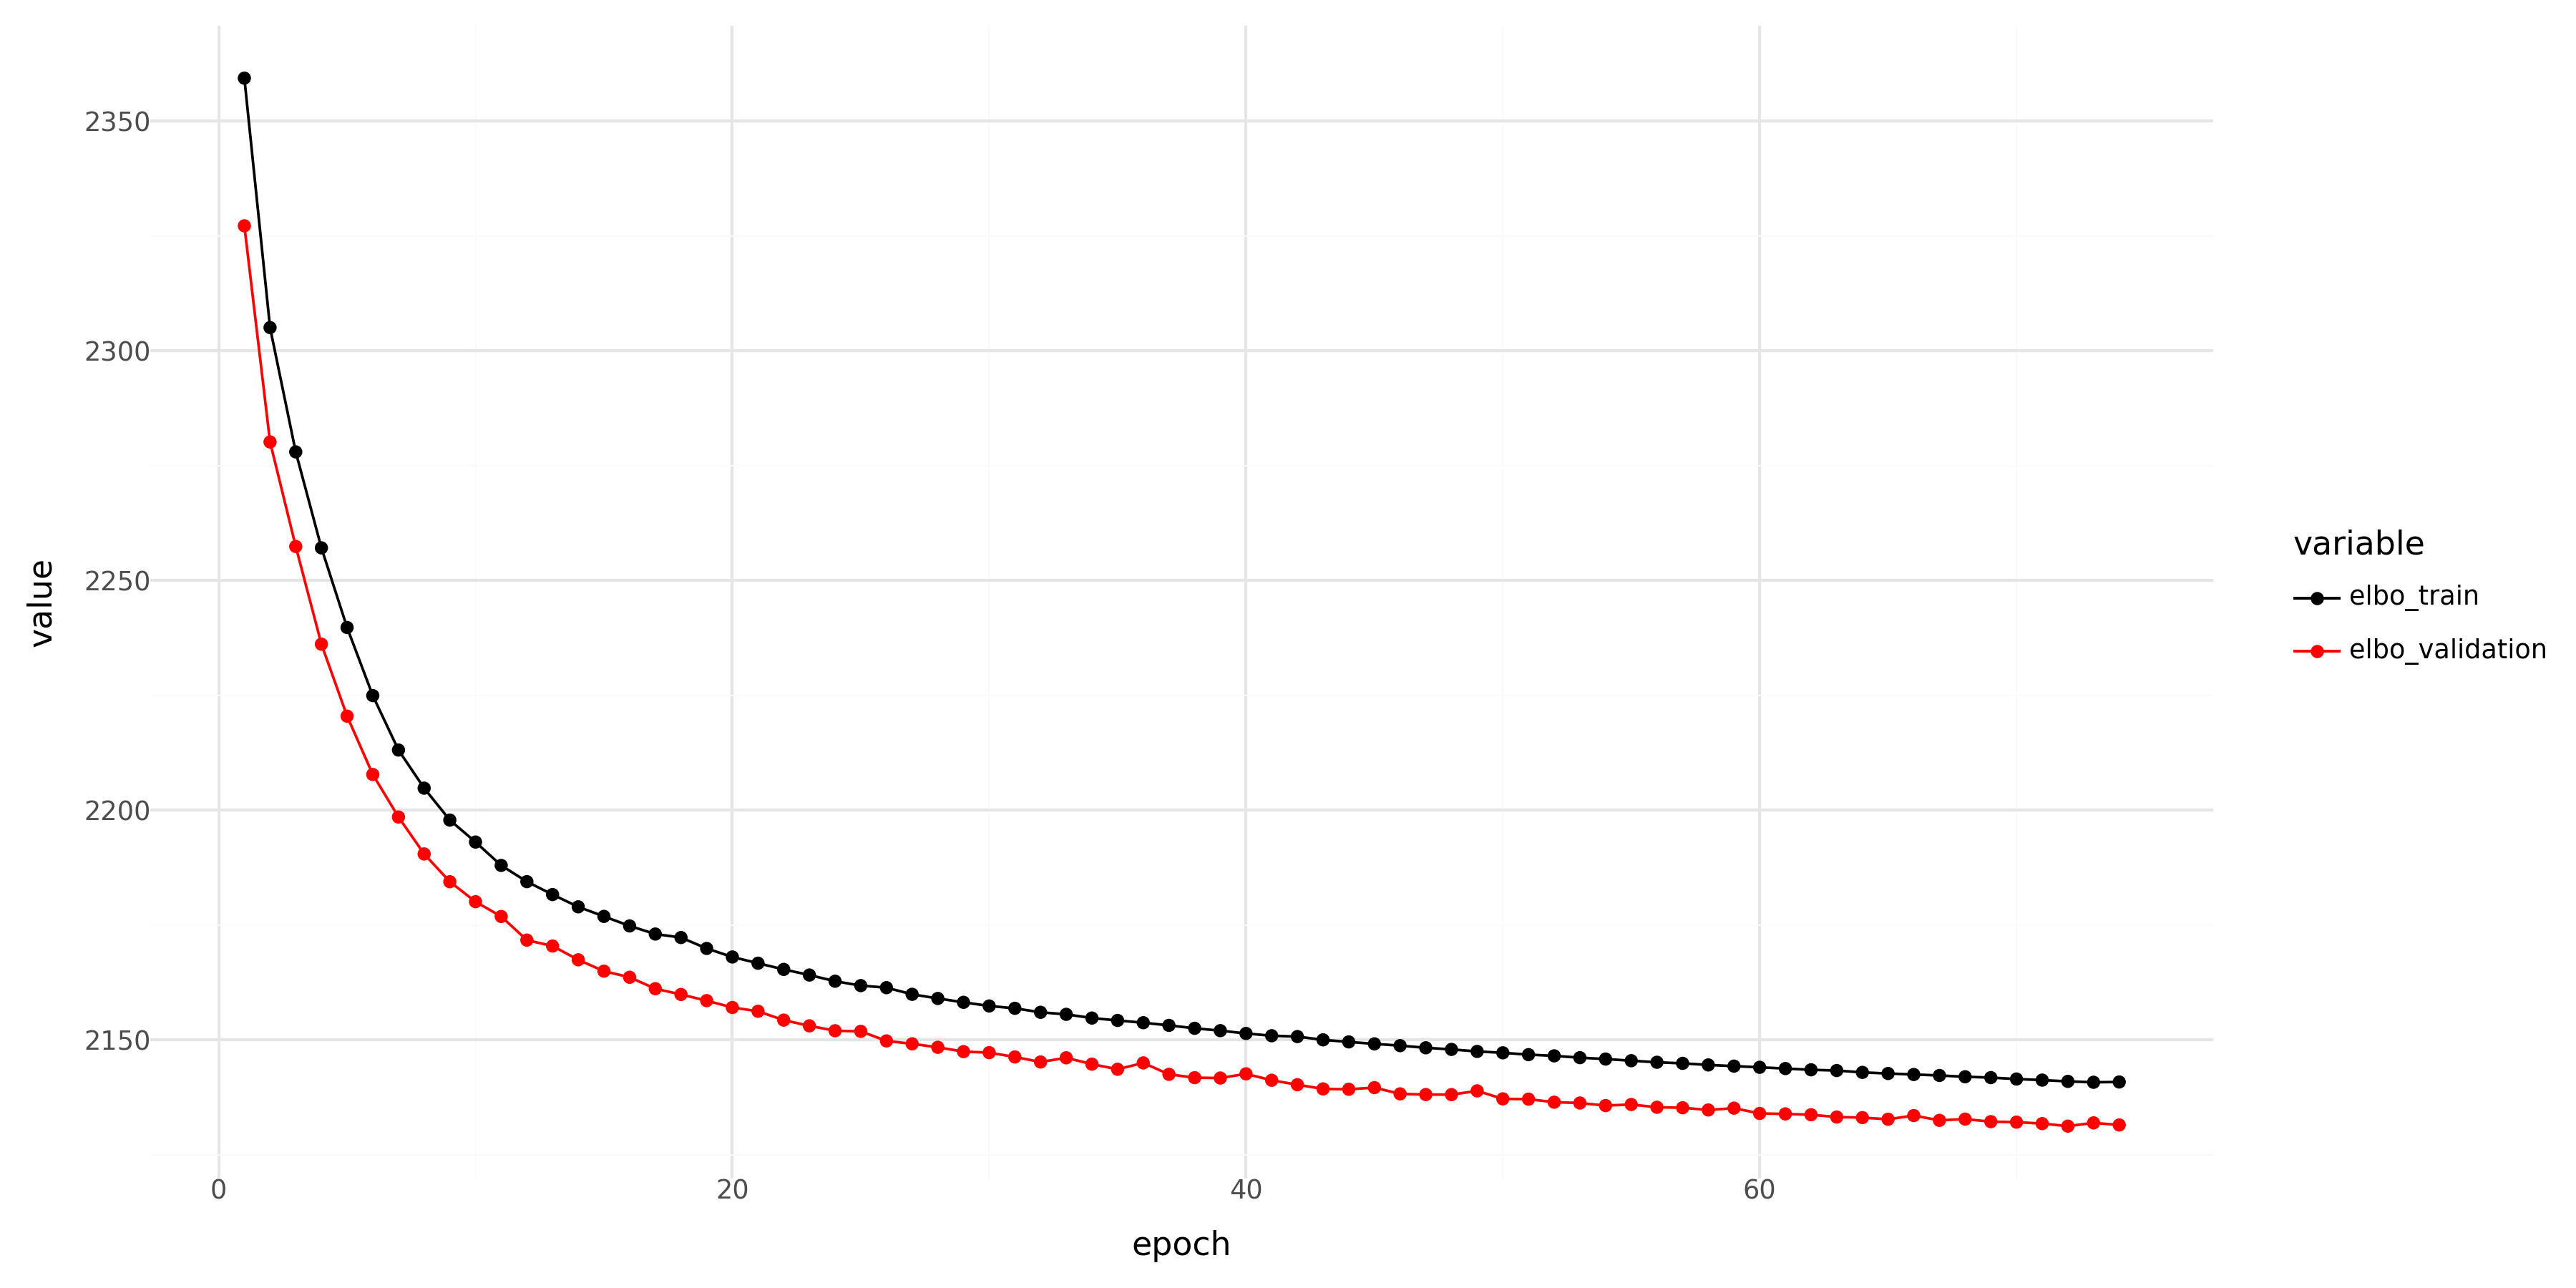

In [25]:
history_df = (
    scvi_model.history['elbo_train'].astype(float)
    .join(scvi_model.history['elbo_validation'].astype(float))
    .reset_index()
    .melt(id_vars = ['epoch'])
)

p.options.figure_size = 12, 6

p_ = (
    p.ggplot(p.aes(x = 'epoch', y = 'value', color = 'variable'), history_df.query('epoch > 0'))
    + p.geom_line()
    + p.geom_point()
    + p.scale_color_manual({'elbo_train': 'black', 'elbo_validation': 'red'})
    + p.theme_minimal()
)

p_.save('fig1.png', dpi = 300)

print(p_)

### Label transfer with `scANVI` 

In [26]:
scanvi_model = scvi.model.SCANVI.from_scvi_model(scvi_model, 'Unknown')

In [27]:
scanvi_model.train(
    60,
    check_val_every_n_epoch=1,
    enable_progress_bar=True,
    devices=[1],
)

INFO     Training for 60 epochs.                                                                                   


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 60/60: 100%|██████████| 60/60 [1:14:24<00:00, 76.76s/it, v_num=1, train_loss_step=2.84e+3, train_loss_epoch=2.12e+3]

`Trainer.fit` stopped: `max_epochs=60` reached.


Epoch 60/60: 100%|██████████| 60/60 [1:14:24<00:00, 74.41s/it, v_num=1, train_loss_step=2.84e+3, train_loss_epoch=2.12e+3]


### Evaluate model performance a la Svensson

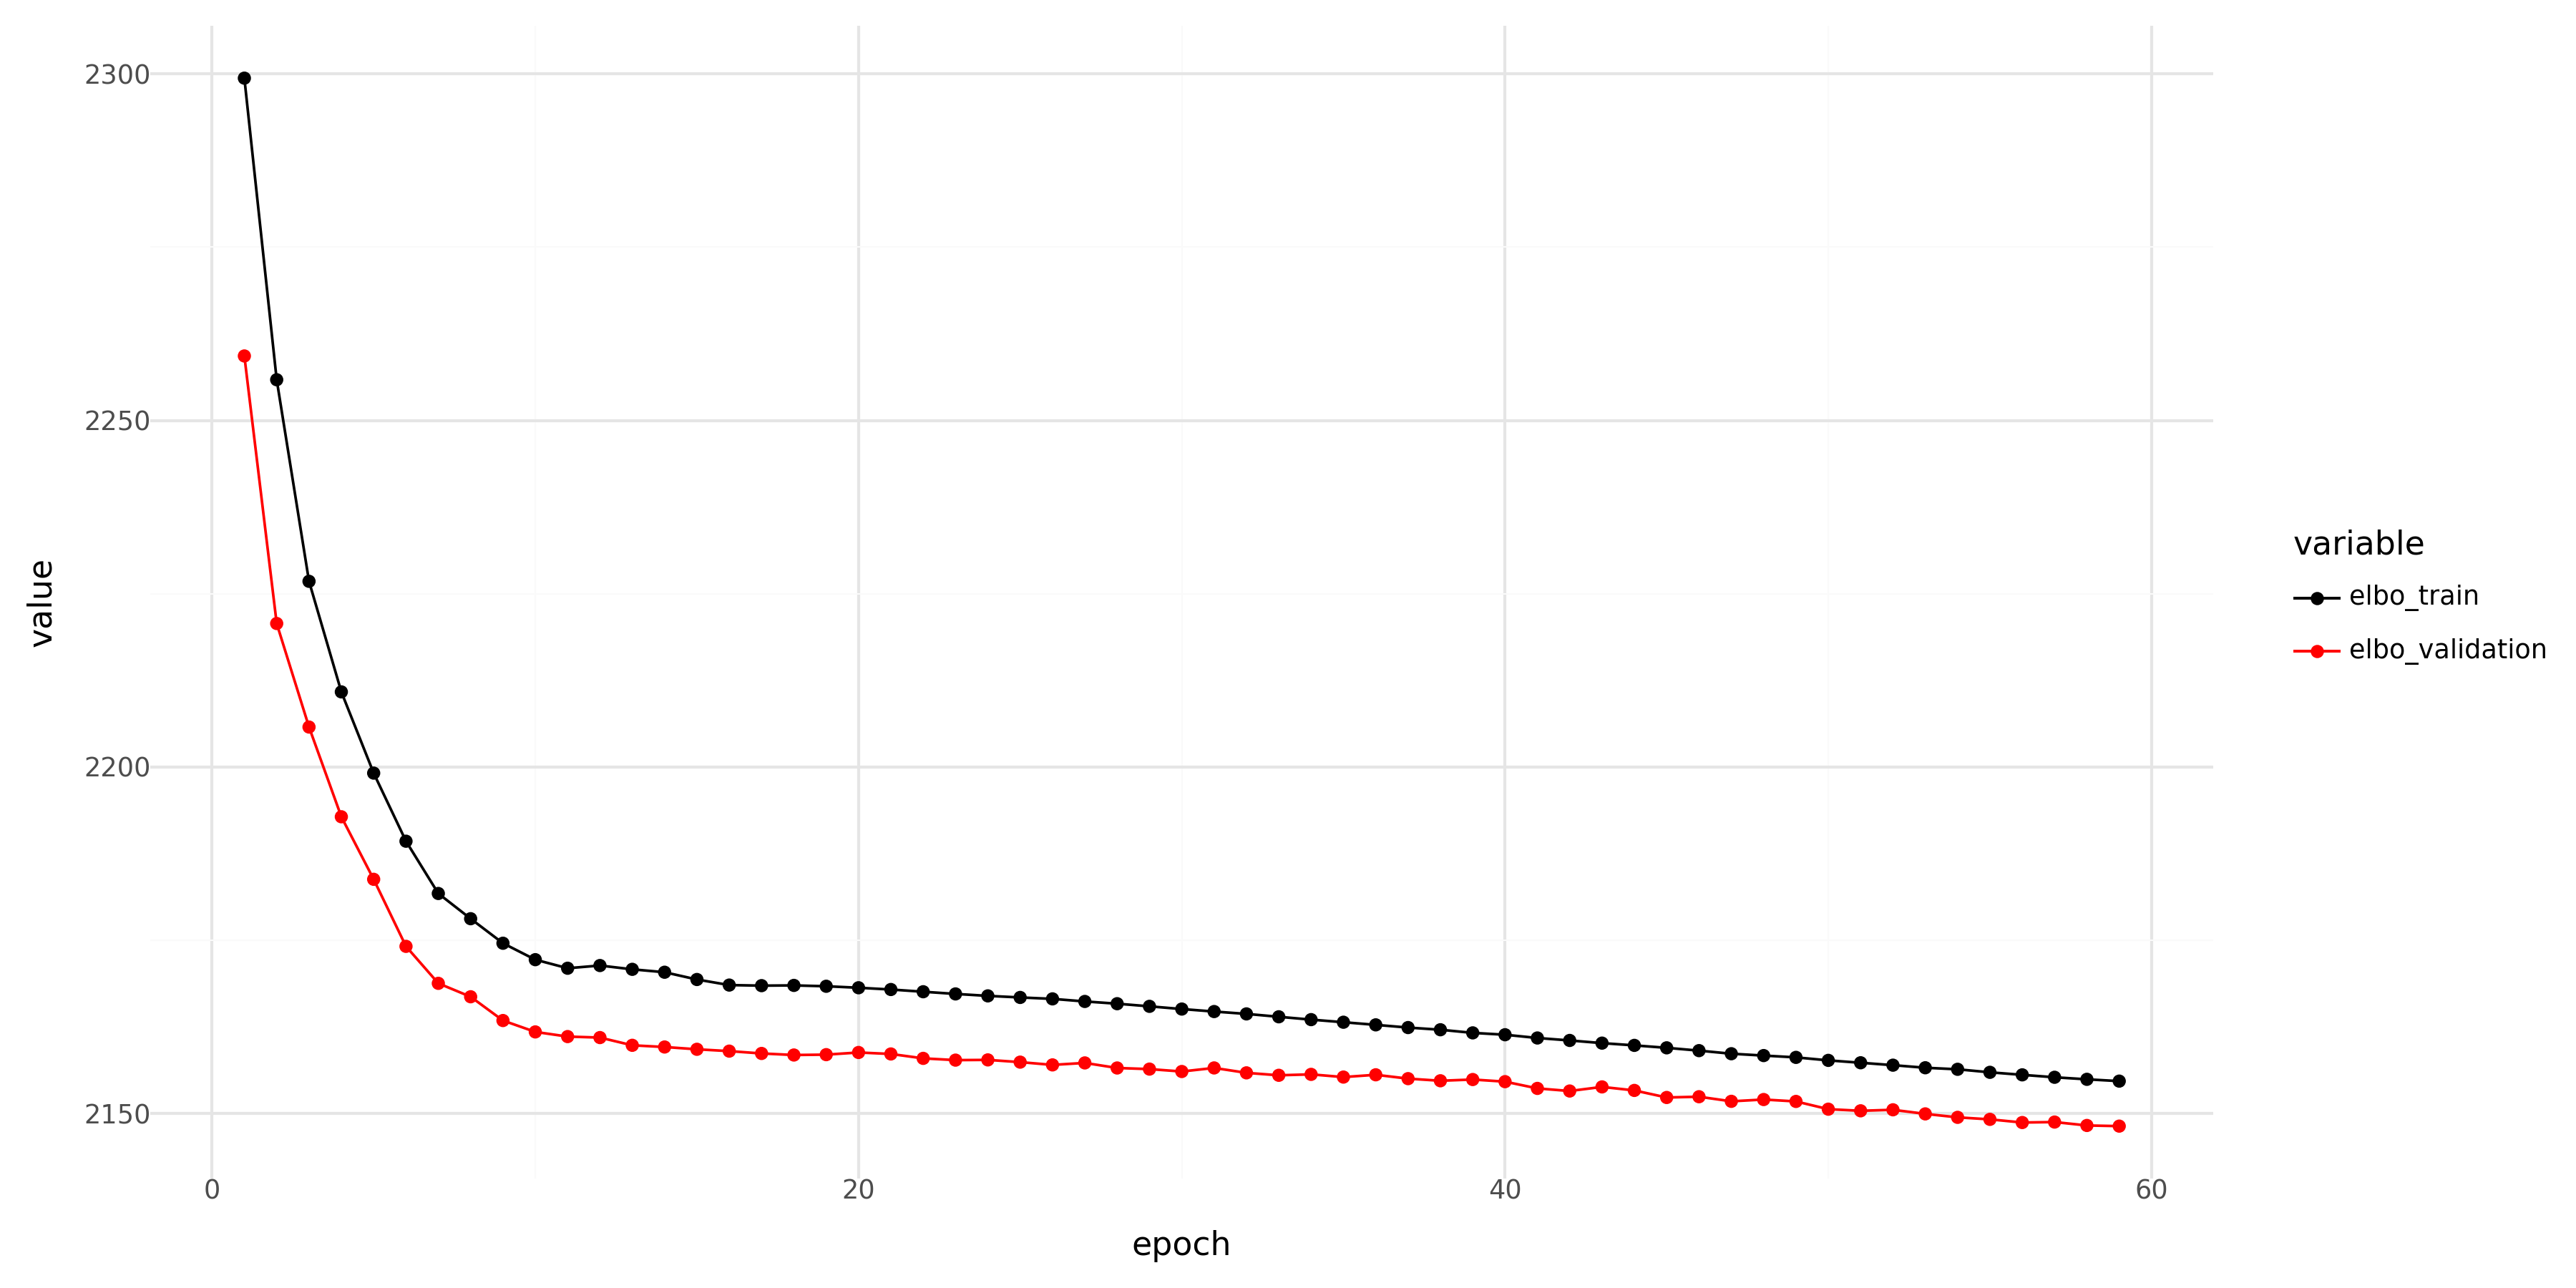

In [28]:
history_df = (
    scanvi_model.history['elbo_train'].astype(float)
    .join(scanvi_model.history['elbo_validation'].astype(float))
    .reset_index()
    .melt(id_vars = ['epoch'])
)

p.options.figure_size = 12, 6

p_ = (
    p.ggplot(p.aes(x = 'epoch', y = 'value', color = 'variable'), history_df.query('epoch > 0'))
    + p.geom_line()
    + p.geom_point()
    + p.scale_color_manual({'elbo_train': 'black', 'elbo_validation': 'red'})
    + p.theme_minimal()
)

p_.save('fig1.png', dpi = 300)

print(p_)

In [29]:
adata.obs["C_scANVI"] = scanvi_model.predict(adata)

- Extract latent representation

In [30]:
adata.obsm["X_scANVI"] = scanvi_model.get_latent_representation(adata)

- Visualise corrected dataset

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:02:26)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:06:14)
the obs value 'sample' has more than 103 categories. Uniform 'grey' color will be used for all categories.


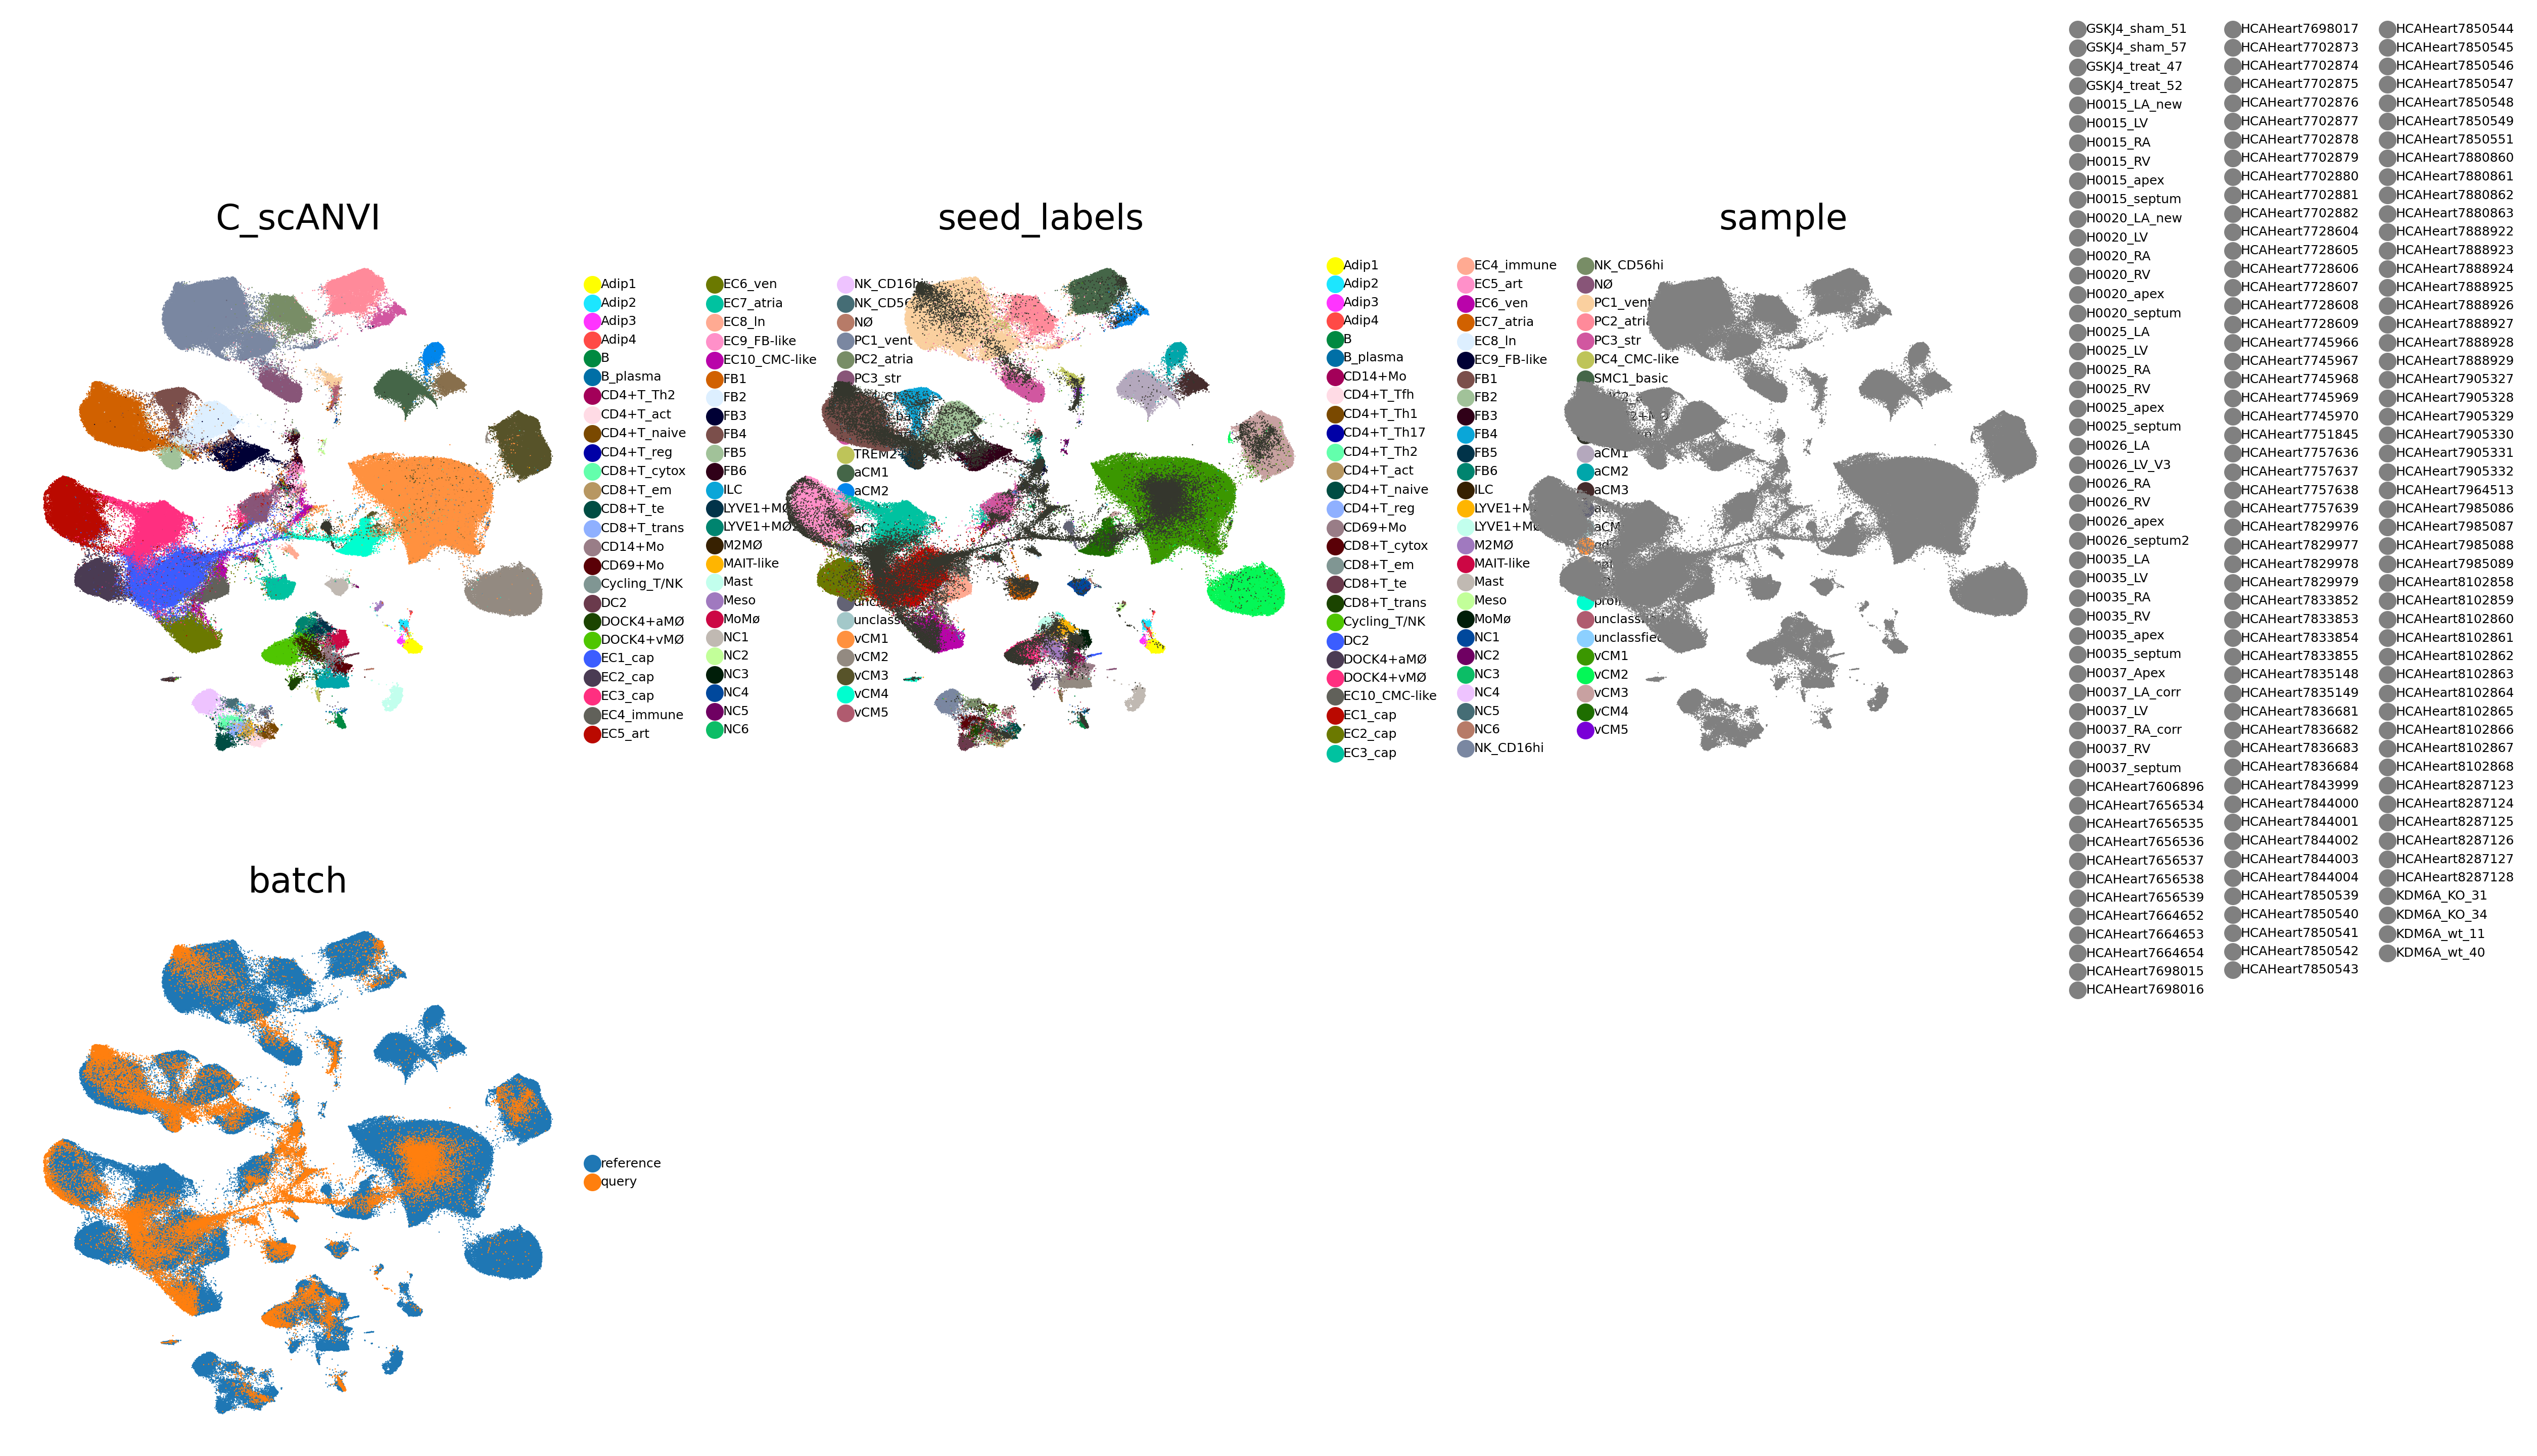

In [31]:
sc.pp.neighbors(adata, use_rep = "X_scANVI", n_neighbors = 50, metric = 'minkowski')
sc.tl.umap(adata, min_dist = 0.3, spread = 4, random_state = 1712)
sc.pl.umap(adata, frameon = False, color = ['C_scANVI', 'seed_labels', 'sample', 'batch'], size = 1, legend_fontsize = 5, ncols = 3)

### Evaluate integration with `scIB`

In [32]:
bm = Benchmarker(
    adata,
    batch_key="sample",
    label_key="C_scANVI",
    embedding_obsm_keys=["X_pca", "X_scVI", "X_scANVI"],
    n_jobs = -1,
)
bm.benchmark()

computing PCA
    with n_comps=50
    finished (0:01:19)


Embeddings:   0%|          | 0/3 [00:00<?, ?it/s]


XlaRuntimeError: FAILED_PRECONDITION: Couldn't get ptxas/nvlink version string: INTERNAL: Couldn't invoke ptxas --version

In [33]:
bm.plot_results_table()

ValueError: at least one array or dtype is required

In [34]:
bm.plot_results_table(min_max_scale = False)

KeyError: 'Batch correction'

### Export annotated object

In [35]:
adata_export_merged = anndata.AnnData(X = adata_raw.X, var = adata_raw.var, obs = adata.obs)
adata_export_merged

AnnData object with n_obs × n_vars = 498641 × 14249
    obs: 'cell_source', 'cell_type', 'donor', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'cell_states', 'seed_labels', 'genotype', 'group', 'file', 'batch', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    var: 'gene_ids-query', 'feature_types-query', 'genome-query', 'modality-query', 'mt-query', 'ribo-query', 'n_cells_by_counts-query', 'mean_counts-query', 'pct_dropout_by_counts-query', 'total_counts-query', 'gene_ids-Harvard-Nuclei-full-reference', 'feature_types-Harvard-Nuclei-full-reference', 'gene_ids-Sanger-Nuclei-full-reference', 'feature_types-Sanger-Nuclei-full-reference', 'gene_ids-Sanger-Cells-full-reference', 'feature_types-Sanger-Cells-full-reference', 'gene_ids-Sanger-CD45-full

In [36]:
adata_export = adata_export_merged[adata_export_merged.obs['batch'].isin(['query'])]
adata_export

View of AnnData object with n_obs × n_vars = 46135 × 14249
    obs: 'cell_source', 'cell_type', 'donor', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'cell_states', 'seed_labels', 'genotype', 'group', 'file', 'batch', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    var: 'gene_ids-query', 'feature_types-query', 'genome-query', 'modality-query', 'mt-query', 'ribo-query', 'n_cells_by_counts-query', 'mean_counts-query', 'pct_dropout_by_counts-query', 'total_counts-query', 'gene_ids-Harvard-Nuclei-full-reference', 'feature_types-Harvard-Nuclei-full-reference', 'gene_ids-Sanger-Nuclei-full-reference', 'feature_types-Sanger-Nuclei-full-reference', 'gene_ids-Sanger-Cells-full-reference', 'feature_types-Sanger-Cells-full-reference', 'gene_ids-Sanger-CD

### Add new gene symbols

In [37]:
query_export = anndata.AnnData(X = query.X, var = query.var, obs = adata_export.obs)
query_export

AnnData object with n_obs × n_vars = 46135 × 32285
    obs: 'cell_source', 'cell_type', 'donor', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'cell_states', 'seed_labels', 'genotype', 'group', 'file', 'batch', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    var: 'gene_ids', 'feature_types', 'genome', 'modality', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

### Revert gene symbols

In [38]:
query_export.var_names = [gene_name.capitalize() for gene_name in query_export.var_names]
query_export.var_names

Index(['Xkr4', 'Gm1992', 'Gm19938', 'Gm37381', 'Rp1', 'Sox17', 'Gm37587',
       'Gm37323', 'Mrpl15', 'Lypla1',
       ...
       'Gm16367', 'Ac163611.1', 'Ac163611.2', 'Ac140365.1', 'Ac124606.2',
       'Ac124606.1', 'Ac133095.2', 'Ac133095.1', 'Ac234645.1', 'Ac149090.1'],
      dtype='object', length=32285)

In [39]:
query_export.obs['C_scANVI'].value_counts()

vCM1             6808
EC1_cap          5340
FB1              5294
EC3_cap          2723
EC5_art          2518
                 ... 
ILC                 2
NC2                 2
NC6                 1
unclassfied.2       1
NC5                 1
Name: C_scANVI, Length: 72, dtype: int64

In [40]:
query_export

AnnData object with n_obs × n_vars = 46135 × 32285
    obs: 'cell_source', 'cell_type', 'donor', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'cell_states', 'seed_labels', 'genotype', 'group', 'file', 'batch', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    var: 'gene_ids', 'feature_types', 'genome', 'modality', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [ ]:
query_export.write_h5ad('../../data/Kdm6aKO_ALL_GEX-CB_scANVI-CellStates_ctl240116.raw.h5ad')